## Road segmentation using Hybrid model, U-Net and DeepLab V3+ and doing Comparitive analysis

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Concatenate, Input, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
EPOCHS = 25
BATCH_SIZE = 10
HEIGHT = 256
WIDTH = 256
N_CLASSES = 13

## Loading Dataset (Cityscape)

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    image = img[:, :256]
    mask = img[:, 256:]
    return image, mask

def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, :, 0]
    for c in range(classes):
        seg_labels[:, :, c] = (img == c).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3)).astype('float')
    colors = sns.color_palette("hls", n_classes)
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:, :, 0] += (segc * colors[c][0])
        seg_img[:, :, 1] += (segc * colors[c][1])
        seg_img[:, :, 2] += (segc * colors[c][2])
    return seg_img

# Data Generator

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i: i + batch_size]
            imgs, segs = [], []
            for file in batch_files:
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)
                imgs.append(image)
                segs.append(labels)
            yield np.array(imgs), np.array(segs)

## Buillding model

## Comparitive analysis

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [12]:
# U-Net Model (Unchanged)
def UNet():
    inputs = Input((HEIGHT, WIDTH, 3))
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Concatenate()([up5, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Concatenate()([up6, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Concatenate()([up7, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(N_CLASSES, 1, activation='softmax')(conv7)
    return Model(inputs, outputs)


# Hybrid Model: EfficientPS + Mask2Former

def hybrid_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    c = BatchNormalization()(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def transformer_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = BatchNormalization()(c)
    return c

def HybridSegmentationModel():
    f = [32, 64, 128, 256, 512]
    inputs = Input((HEIGHT, WIDTH, 3))

    c1, p1 = hybrid_block(inputs, f[0])  # EfficientPS Block
    c2, p2 = hybrid_block(p1, f[1])
    c3, p3 = hybrid_block(p2, f[2])
    c4, p4 = hybrid_block(p3, f[3])

    bn = transformer_block(p4, f[4])  # Mask2Former Transformer Block

    u1 = UpSampling2D((2, 2))(bn)
    u1 = Conv2D(f[3], (3, 3), activation='relu', padding='same')(u1)
    u1 = Concatenate()([u1, c4])
    
    u2 = UpSampling2D((2, 2))(u1)
    u2 = Conv2D(f[2], (3, 3), activation='relu', padding='same')(u2)
    u2 = Concatenate()([u2, c3])
    
    u3 = UpSampling2D((2, 2))(u2)
    u3 = Conv2D(f[1], (3, 3), activation='relu', padding='same')(u3)
    u3 = Concatenate()([u3, c2])
    
    u4 = UpSampling2D((2, 2))(u3)
    u4 = Conv2D(f[0], (3, 3), activation='relu', padding='same')(u4)
    u4 = Concatenate()([u4, c1])
    
    outputs = Conv2D(N_CLASSES, (1, 1), padding="same", activation="softmax")(u4)
    
    model = Model(inputs, outputs)
    return model

# Corrected DeepLabV3+ Model
def DeepLabV3Plus():
    # Load ResNet50 as backbone
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze ResNet50 layers

    x = base_model.output  
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
    
    x = UpSampling2D(size=(8, 8))(x) 
    
    skip = base_model.get_layer('conv2_block3_out').output  
    
    x = Concatenate()([x, skip]) 
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  
    x = UpSampling2D(size=(4, 4))(x)  
    
    # Final output layer
    outputs = Conv2D(N_CLASSES, (1, 1), padding='same', activation='softmax')(x)  
    
    return Model(base_model.input, outputs)

# Metrics Calculation (Unchanged)
def compute_metrics(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1).flatten()
    y_pred = np.argmax(y_pred, axis=-1).flatten()
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / (union + 1e-8)
    
    dice = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)
    
    accuracy = np.mean(y_true == y_pred)
    
    return iou, dice, accuracy


Training Hybrid Model...
Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.5630 - loss: 1.5651 - val_accuracy: 0.5069 - val_loss: 1.5900
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.7194 - loss: 0.9967 - val_accuracy: 0.6650 - val_loss: 1.1793
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.7302 - loss: 0.9501 - val_accuracy: 0.6181 - val_loss: 1.3519
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.7550 - loss: 0.8649 - val_accuracy: 0.7408 - val_loss: 0.9290
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.7684 - loss: 0.8124 - val_accuracy: 0.7548 - val_loss: 0.8561
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.7710 - loss: 0.8050 - val_accuracy: 0.6951 - val_loss: 1.1015
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.7802 - loss: 0.7620 - val_accuracy: 0.7766 - val_loss: 0.7767
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - a

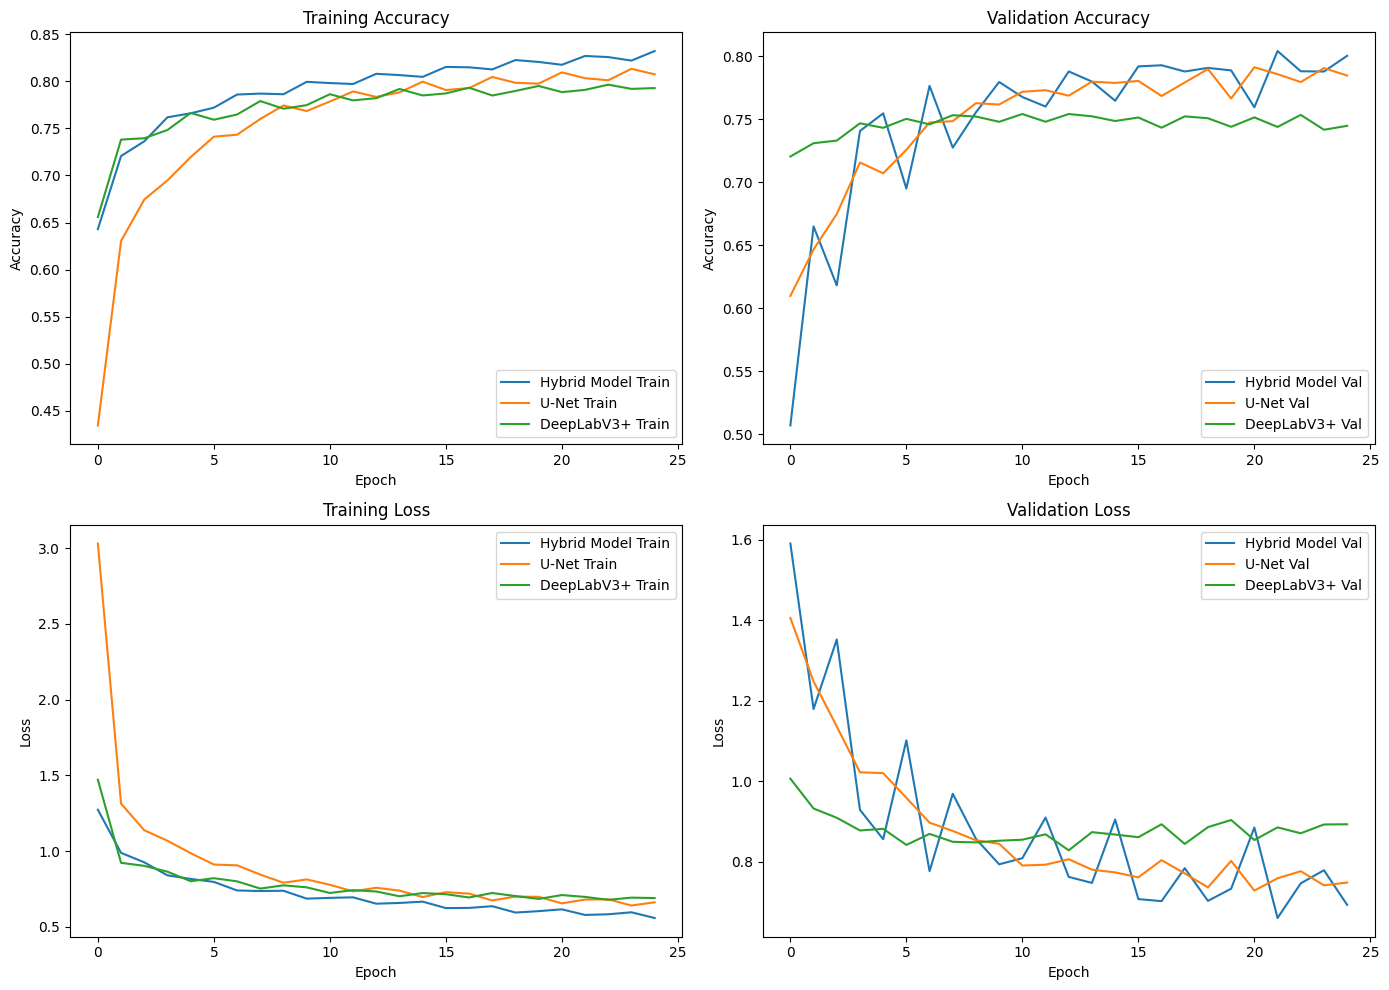

In [13]:
# Metrics Calculation
def compute_metrics(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1).flatten()
    y_pred = np.argmax(y_pred, axis=-1).flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / (union + 1e-8)
    dice = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)
    accuracy = np.mean(y_true == y_pred)
    return iou, dice, accuracy

# Training and Evaluation with History
train_folder = "../input/cityscapes-image-pairs/cityscapes_data/train"
valid_folder = "../input/cityscapes-image-pairs/cityscapes_data/val"
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)

models = {
    "Hybrid Model": HybridSegmentationModel(),
    "U-Net": UNet(),
    "DeepLabV3+": DeepLabV3Plus()
}

history_dict = {}  # Store training history for plotting
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'{name.lower().replace(" ", "_")}_best.keras', monitor='val_accuracy', save_best_only=True)
    
    # Train and store history
    history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, steps_per_epoch=100, validation_steps=20, callbacks=[checkpoint])
    history_dict[name] = history.history
    
    # Evaluate on validation set
    val_imgs, val_masks = next(val_gen)
    preds = model.predict(val_imgs)
    iou, dice, acc = compute_metrics(val_masks, preds)
    results[name] = {"IoU": iou, "Dice": dice, "Pixel Accuracy": acc}
    
    # Save model
    model.save(f"{name.lower().replace(' ', '_')}.h5")

# Print Results
print("\nPerformance Comparison:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  IoU: {metrics['IoU']:.4f}")
    print(f"  Dice Coefficient: {metrics['Dice']:.4f}")
    print(f"  Pixel Accuracy: {metrics['Pixel Accuracy']:.4f}\n")

# Plotting Accuracies and Losses
plt.figure(figsize=(14, 10))

# Training Accuracy
plt.subplot(2, 2, 1)
for name, history in history_dict.items():
    plt.plot(history['accuracy'], label=f'{name} Train')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 2)
for name, history in history_dict.items():
    plt.plot(history['val_accuracy'], label=f'{name} Val')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training Loss
plt.subplot(2, 2, 3)
for name, history in history_dict.items():
    plt.plot(history['loss'], label=f'{name} Train')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 4)
for name, history in history_dict.items():
    plt.plot(history['val_loss'], label=f'{name} Val')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


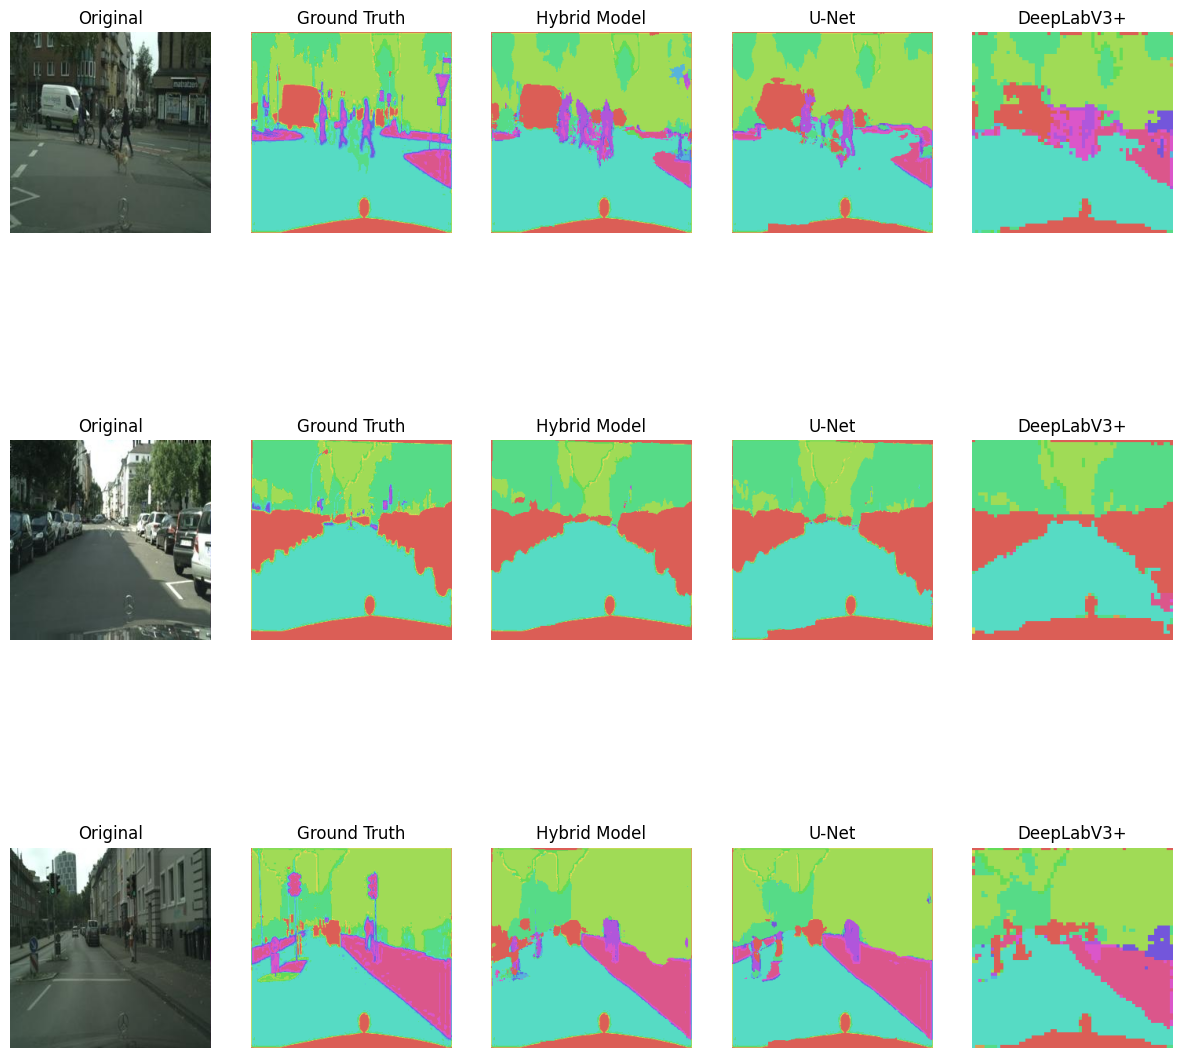

In [14]:
# Visualization (Unchanged)
def visualize_comparison(val_gen, models, num_samples=3):
    imgs, masks = next(val_gen)
    fig, axes = plt.subplots(num_samples, len(models) + 2, figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(imgs[i])
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(give_color_to_seg_img(np.argmax(masks[i], axis=-1)))
        axes[i, 1].set_title("Ground Truth")
        for j, (name, model) in enumerate(models.items(), 2):
            pred = model.predict(np.expand_dims(imgs[i], axis=0))
            axes[i, j].imshow(give_color_to_seg_img(np.argmax(pred[0], axis=-1)))
            axes[i, j].set_title(name)
        for ax in axes[i]: ax.axis('off')
    plt.show()

visualize_comparison(val_gen, models)

### As you see we have our Hybrid has the more accuracy and less loss compared to others